# Predicting Students Outcome

## Business Problem

Academic achievement is crucial in educational environment, as it is important indicator of an educational institution’s performance. Early prediction of students’ performance can help educational institutions to navigate students to the right direction, provide the needed actions at the right moment, and to plan the appropriate training to improve students’ success rate. 

## Data 

The datasets for this project were obtained from **Open University Learning Analytics**. It contains data about **courses, students' demographics,** and their **interactions with Virtual Learning Environment** (VLE) for seven selected courses (called modules). The dataset consists of tables connected through **unique identifiers**. All tables are stored in the csv format. The tables available are following:
-	cources.csv
-	assessments.csv
-	vle.csv
-	studentsInfo.csv
-	studentsRegistration.csv
-	studentAssessment.csv
-	studentVle.csv


**Link to Datasets:** https://analyse.kmi.open.ac.uk/open_dataset#description



# Data Preparation Overview

The full data cleaning process is stored in [data_cleaning](./data_cleaning.ipynb) notebook in notebooks folder.

Before proceeding to EDA and Modeling the datasets were closely examined and cleaned. I've **removed features** that had missing values or were not relevant to project goals. In addition, for the purpose of modeling, I've selected **observations only by the half term of the course** - 135 days and **dropped observations** that had **"withdrawn" result** within this timeframe. The **scores of assessments** per course were **summed up per student and averaged**. **Number of clicks** were **summed up** per each student on a given course. The **index_row** feature were created to store each student information as unique index for following EDA. 
At the end of the notebook, I've **merged** all relevant and modified features **into one dataframe** that has been stored in data folder as **clean_data.csv** file. 



# Import Packages

* Import standard libraries and necessary packages for data cleaning, EDA, transformation, modeling and evaluation. In addition, import user defined functions and classess.

In [1]:
import pandas as pd
import numpy as np
import scipy.stats as stats

import statsmodels.api as sm

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from imblearn.over_sampling import SMOTE
from imblearn.pipeline import make_pipeline

from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer

from sklearn.model_selection import train_test_split, cross_val_score, KFold, GridSearchCV

from sklearn.linear_model import LogisticRegression as LR
from sklearn.neighbors import KNeighborsClassifier as KNN
from sklearn.tree import DecisionTreeClassifier as DT
from sklearn.ensemble import RandomForestClassifier as RFC, GradientBoostingClassifier as GBC
from sklearn.cluster import KMeans
from xgboost import XGBClassifier as XGB


from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import precision_score, recall_score, accuracy_score, f1_score, roc_curve, auc
from sklearn.inspection import permutation_importance

# Import additional files with user-defined statistical functions
import sys
import os

module_path = os.path.abspath(os.path.join('../../src'))
if module_path not in sys.path:
    sys.path.append(module_path)
    
import explore_data as ed 
import model_functions as mf
import model_history as mh

* Set notebook's visual parameters.

In [2]:
pd.options.display.max_rows = 500
pd.options.display.max_columns = 100

plt.style.use('seaborn-dark')
sns.set_theme('talk')

# Upload Datasets

* Upload the clean_data.csv from data folder. Save id_student feature as object data type

In [3]:
df = pd.read_csv('../../data/clean_data.csv', dtype={"id_student": str})
df.head(10)

,index_row,code_module,code_presentation,id_student,date_registration,sum_click,gender,region,highest_education,imd_band,age_band,num_of_prev_attempts,studied_credits,disability,final_result,mean_score,module_presentation_length
0,DDD2014J610197,DDD,2014J,610197,88,458,M,North Western Region,Lower Than A Level,0-10%,0-35,0,60,N,Pass,86.50,262
1,DDD2014J609245,DDD,2014J,609245,136,1107,M,Scotland,HE Qualification,80-90%,55<=,0,60,N,Pass,80.00,262
2,DDD2014J609556,DDD,2014J,609556,107,663,M,West Midlands Region,A Level or Equivalent,90-100%,0-35,0,60,N,Pass,86.00,262
3,DDD2014J610828,DDD,2014J,610828,99,729,M,East Anglian Region,A Level or Equivalent,80-90%,0-35,0,90,N,Fail,65.25,262
4,DDD2014J611790,DDD,2014J,611790,143,453,F,South Region,A Level or Equivalent,40-50%,0-35,0,60,Y,Pass,87.50,262
5,DDD2014J611013,DDD,2014J,611013,23,155,M,South Region,Lower Than A Level,30-40%,0-35,0,60,N,Pass,64.50,262
6,DDD2014J611159,DDD,2014J,611159,30,318,M,East Anglian Region,A Level or Equivalent,60-70%,0-35,0,60,N,Pass,75.25,262
7,DDD2014J608842,DDD,2014J,608842,162,977,M,South West Region,A Level or Equivalent,70-80%,0-35,0,60,N,Pass,75.00,262
8,DDD2014J606837,DDD,2014J,606837,109,278,M,South West Region,Lower Than A Level,70-80%,35-55,0,60,N,Fail,85.00,262
9,DDD2014J605876,DDD,2014J,605876,129,2122,M,North Western Region,A Level or Equivalent,20-30%,0-35,0,60,N,Pass,93.00,262


### Descriptive Analysis

In [4]:
df.describe()

,date_registration,sum_click,num_of_prev_attempts,studied_credits,mean_score,module_presentation_length
count,20224.000000,20224.000000,20224.000000,20224.000000,20224.000000,20224.000000
mean,66.040991,887.443137,0.147449,74.658821,74.543012,256.214399
std,46.528177,1011.110836,0.455741,36.771940,14.972948,13.142648
min,0.000000,1.000000,0.000000,30.000000,0.000000,234.000000
25%,29.000000,262.000000,0.000000,60.000000,66.500000,241.000000
50%,53.000000,557.000000,0.000000,60.000000,77.333333,262.000000
75%,94.000000,1122.000000,0.000000,90.000000,85.428571,268.000000
max,310.000000,13594.000000,6.000000,630.000000,100.000000,269.000000


* Average course length is 256 days.
* Average days for registration before the course start is 66 days.
* On average, students make 887 clicks on online sources.
* Average score is 74.5


## Plot Histogram for Numeric Features

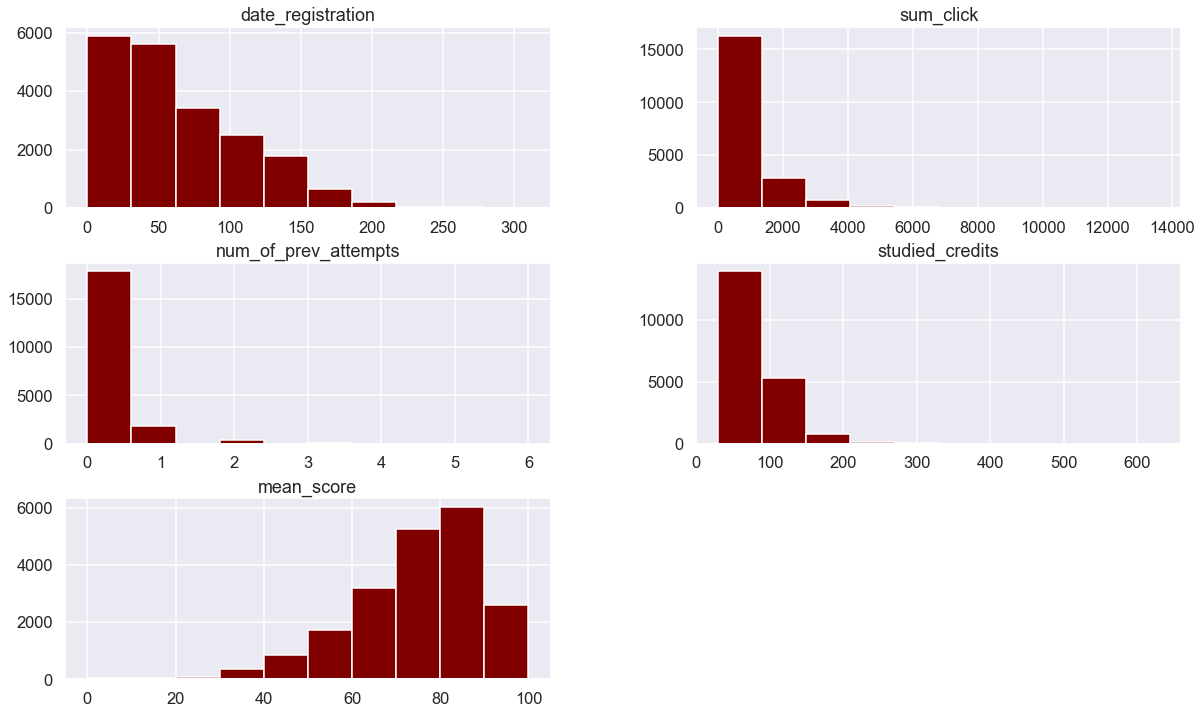

In [5]:
cols_num =['date_registration', 'sum_click', 'num_of_prev_attempts', 
            'studied_credits', 'mean_score']

df[cols_num].hist(figsize = (20,12), edgecolor="w", facecolor='maroon');

**Results:**

* Majority of the students register to courses within 50 days in advance
* Most of the students make within 2000 clicks on online Vle platform
* Only few students have more that 1 attempt 
* Majority have less than 100 studied credits

## Final Result vs Number of Students

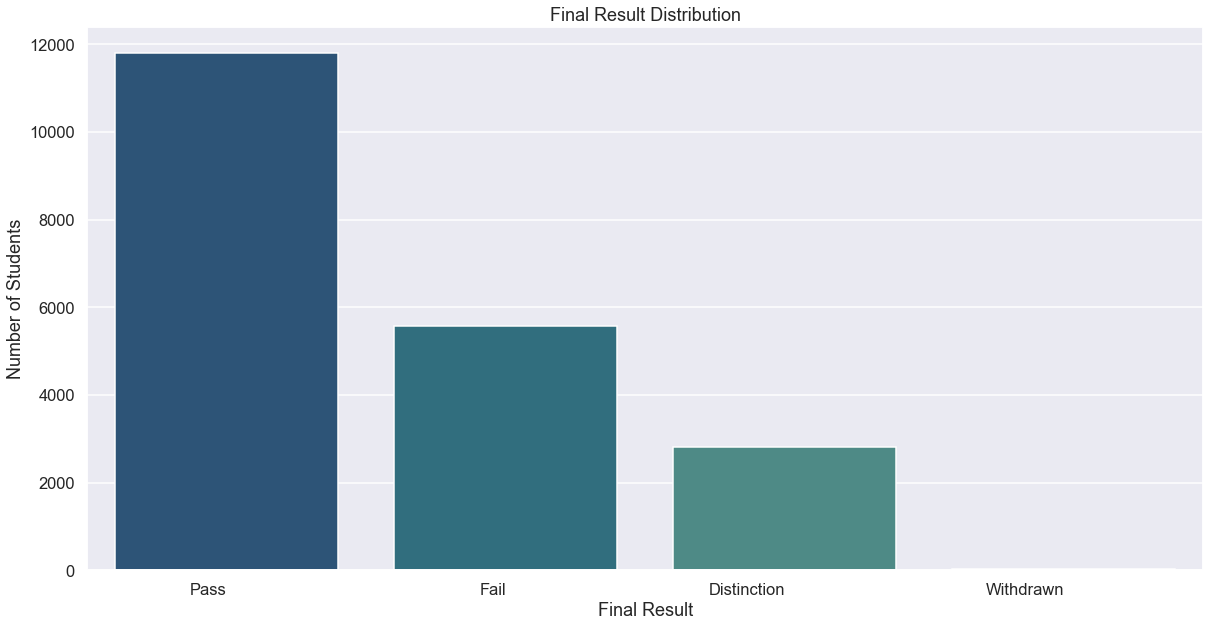

In [6]:
plt.figure(figsize =(20,10))
plt.xticks(horizontalalignment='right')

ax = sns.countplot(x="final_result", data=df,
                   order = df['final_result'].value_counts().index, 
                   palette = 'crest_r')

plt.xlabel('Final Result')
plt.ylabel('Number of Students')
plt.title('Final Result Distribution')
plt.show()

In [7]:
df.final_result.value_counts()

Pass           11807
Fail            5576
Distinction     2821
Withdrawn         20
Name: final_result, dtype: int64

* After data cleaning, the dataset has only 20 observations of withdrawal result. And majority of observations have passing results.


## Code Module vs. Final Result 

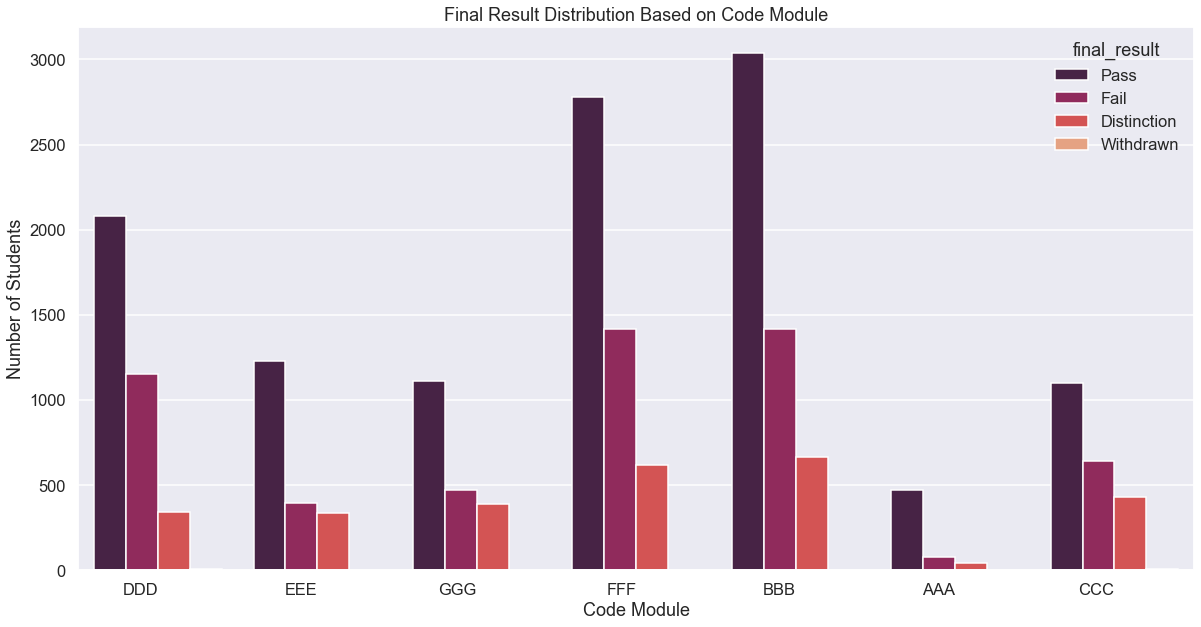

In [8]:
fig, ax = plt.subplots(figsize =(20,10))
plt.xticks(horizontalalignment='right')

sns.countplot(x="code_module", hue="final_result", palette="rocket", data=df)

plt.xlabel('Code Module')
plt.ylabel('Number of Students')
plt.title('Final Result Distribution Based on Code Module')
plt.show()

* Most of students are enrolled in FFF and BBB courses. There are twice as less failing students in most of the couses as are passing.

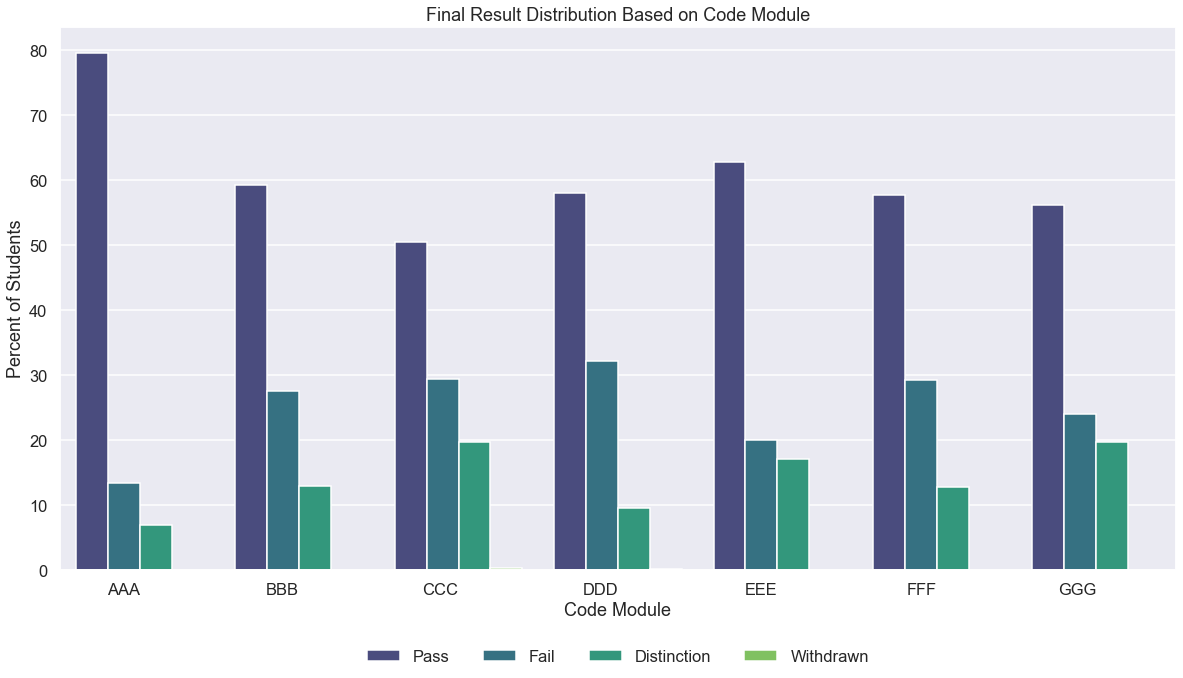

In [9]:
code_pnt = df.groupby('code_module')['final_result'].value_counts(normalize = True).reset_index(name='Percentage')
code_pnt['Percentage'] = code_pnt['Percentage'] * 100
fig, ax = plt.subplots(figsize =(20,10))
plt.xticks(horizontalalignment='right')

sns.barplot(x='code_module', y ='Percentage',data=code_pnt,  hue='final_result', palette='viridis')

plt.xlabel('Code Module')
plt.ylabel('Percent of Students')
plt.title('Final Result Distribution Based on Code Module')
plt.legend(loc = 'lower center', bbox_to_anchor=(0.5, -0.2), ncol = 4)
plt.show()

### Chi- Square Test

In [10]:
cross_tab = pd.crosstab(df['code_module'], df['final_result'])

In [11]:
chi_sq, p_val, dof, con_table = stats.chi2_contingency(cross_tab)
print(f'chi-squared = {chi_sq}')
print(f'p-value= {p_val}')
print(f'degrees of freedom = {dof}')

chi-squared = 415.5823687302602
p-value= 5.127389662809344e-77
degrees of freedom = 18


* Based on Chi-Squre Test Results p-value, the **code_module has statistically significant relation** to final_result.

In [12]:
ed.percentage(cross_tab)

,Pass,Fail,Withdraw,Distinct,Success,Failure
AAA,79.66,13.39,0.0,6.95,86.61,13.39
BBB,59.27,27.67,0.06,13.0,72.27,27.73
CCC,50.46,29.46,0.32,19.76,70.22,29.78
DDD,58.07,32.26,0.14,9.53,67.6,32.4
EEE,62.79,20.11,0.0,17.1,79.89,20.11
FFF,57.75,29.36,0.08,12.81,70.56,29.44
GGG,56.18,24.01,0.05,19.76,75.94,24.06


* Based on table above, the course that has **smallest rate of passing is DDD**, and the course with **highest rate of passing is AAA.** The **CCC and GGG courses** have highest **rate of distinct success**

## Final Result Distribution Based on Gender 

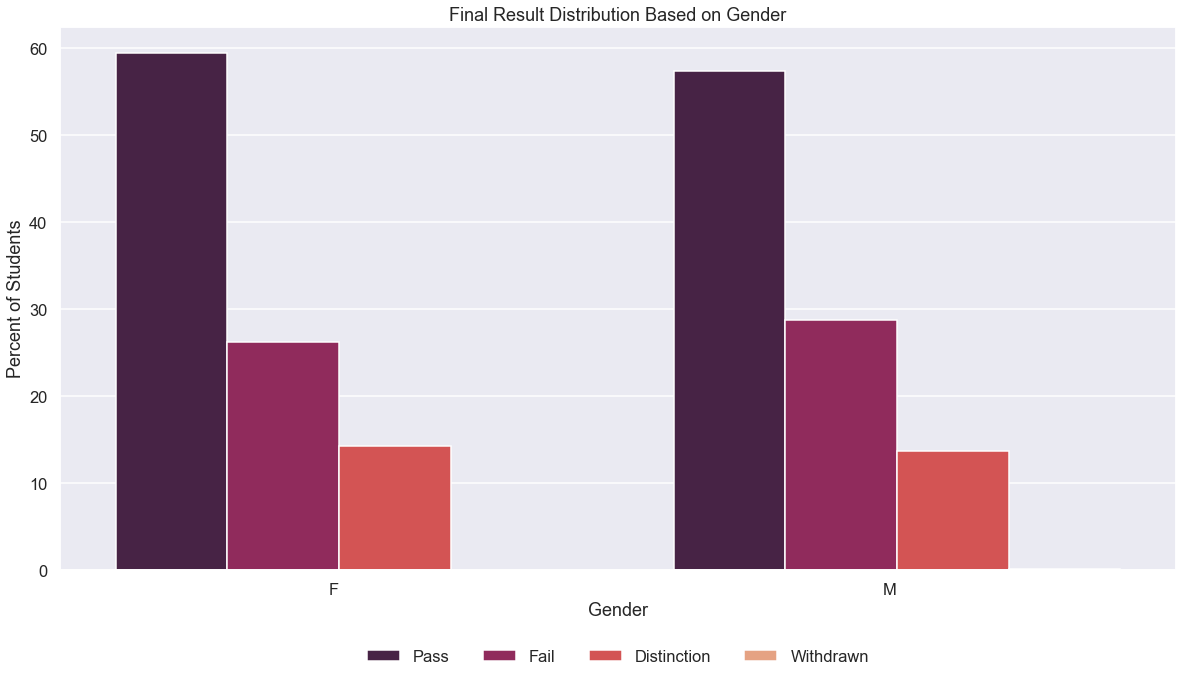

In [13]:
gender_pnt = df.groupby('gender')['final_result'].value_counts(normalize = True).reset_index(name='Percentage')
gender_pnt['Percentage'] = gender_pnt['Percentage'] * 100
fig, ax = plt.subplots(figsize =(20,10))
plt.xticks(horizontalalignment='right')

sns.barplot(x='gender', y ='Percentage',data=gender_pnt,  hue='final_result', palette='rocket')

plt.xlabel('Gender')
plt.ylabel('Percent of Students')
plt.title('Final Result Distribution Based on Gender')
plt.legend(loc = 'lower center', bbox_to_anchor=(0.5, -0.2), ncol = 4)
plt.show()

* Based on the graph, **59% of female student pass the course**, while only **57% of male students pass the course.**
* The rate of **failing students is higher for male students.**

### Chi-Square Test

In [14]:
cross_tab = pd.crosstab(df['gender'], df['final_result'])

In [15]:
chi_sq, p_val, dof, con_table = stats.chi2_contingency(cross_tab)
print(f'Chi-Squared = {chi_sq}')
print(f'p-value= {p_val}')
print(f'Degrees of Freedom = {dof}')

Chi-Squared = 18.916851448966227
p-value= 0.00028443774018634506
Degrees of Freedom = 3


* The **low p-value** indicates that there is a **statistically significant relation** between gender and outcome.

In [16]:
ed.percentage(cross_tab)
cross_tab

final_result,Distinction,Fail,Pass,Withdrawn
gender,,,,
F,1335,2456,5578,6
M,1486,3120,6229,14


In [17]:
ed.percentage(cross_tab)

,Pass,Fail,Withdraw,Distinct,Success,Failure
F,59.5,26.2,0.06,14.24,73.74,26.26
M,57.42,28.76,0.13,13.7,71.12,28.89


* Women have slightly greater rate of passing than men. Number of male students that withdrew from course is slightly higher than female ones.

## Region and Final Result

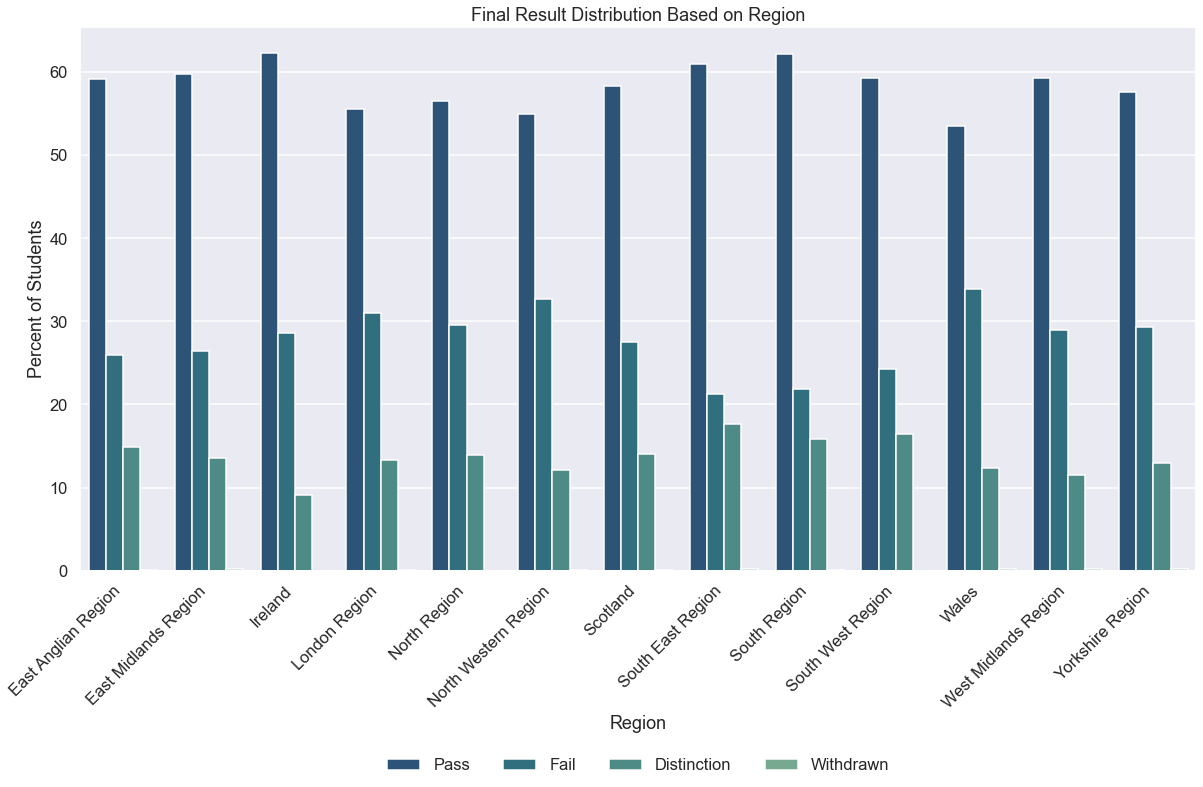

In [18]:
reg_pnt = df.groupby('region')['final_result'].value_counts(normalize = True).reset_index(name='Percentage')
reg_pnt['Percentage'] = reg_pnt['Percentage'] * 100
fig, ax = plt.subplots(figsize =(20,10))
plt.xticks(rotation = 45, horizontalalignment='right')

sns.barplot(x='region', y ='Percentage',data=reg_pnt,  hue='final_result', palette='crest_r')

plt.xlabel('Region')
plt.ylabel('Percent of Students')
plt.title('Final Result Distribution Based on Region')
plt.legend(loc = 'lower center', bbox_to_anchor=(0.5, -0.4), ncol = 4)
plt.show()

In [19]:
cross_tab = pd.crosstab(df['region'], df['final_result'])

In [20]:
chi_sq, p_val, dof, con_table = stats.chi2_contingency(cross_tab)
print(f'Chi-Squared = {chi_sq}')
print(f'p-value= {p_val}')
print(f'Degrees of Freedom = {dof}')

Chi-Squared = 186.7995498595146
p-value= 2.93651874987042e-22
Degrees of Freedom = 36


* The low p-value indicates that there is a **statistically significant relation** between region and outcome.

In [21]:
ed.percentage(cross_tab)

,Pass,Fail,Withdraw,Distinct,Success,Failure
East Anglian Region,59.21,25.91,0.05,14.84,74.05,25.96
East Midlands Region,59.8,26.39,0.2,13.61,73.41,26.59
Ireland,62.33,28.59,0.0,9.08,71.41,28.59
London Region,55.61,30.98,0.1,13.31,68.92,31.08
North Region,56.55,29.55,0.0,13.9,70.45,29.55
North Western Region,55.0,32.74,0.12,12.15,67.15,32.86
Scotland,58.31,27.56,0.09,14.04,72.35,27.65
South East Region,60.97,21.22,0.14,17.67,78.64,21.36
South Region,62.17,21.88,0.05,15.9,78.07,21.93
South West Region,59.28,24.22,0.0,16.5,75.78,24.22


* Smallest rate of passing is observed in **Whales region**, while **South and South East regions** have highest rates. in addition, **South East Region** has highest value of distinc results.
* **East Midlands Region** has highest rate of withdrawing results

## Education Level vs Results

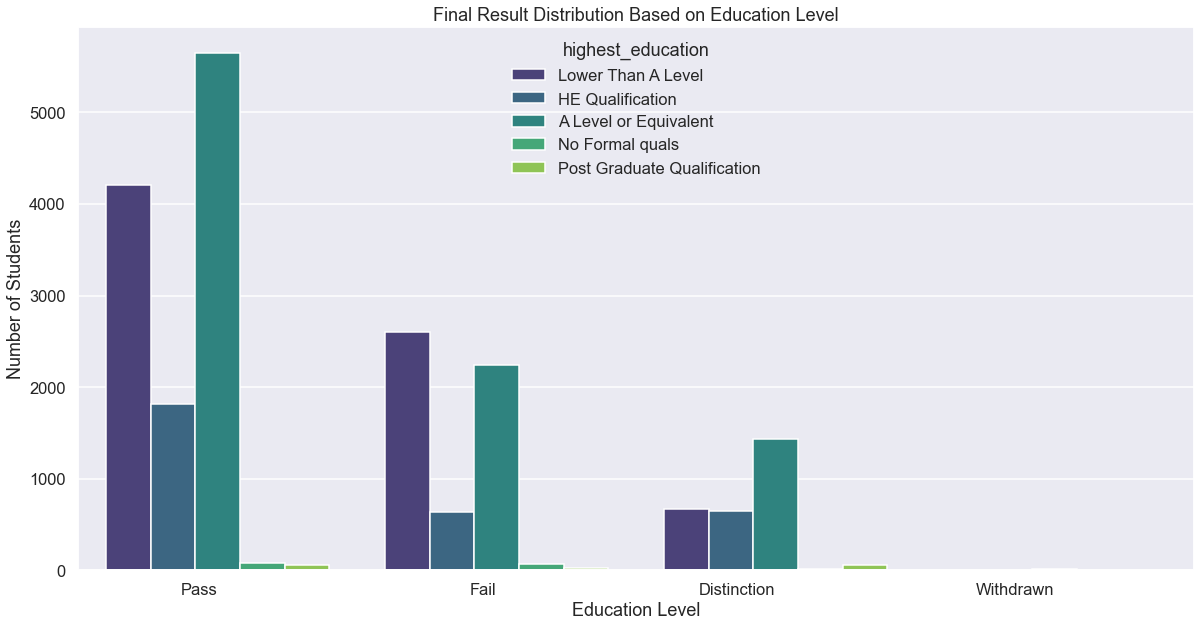

In [22]:
fig, ax = plt.subplots(figsize =(20,10))
plt.xticks(horizontalalignment='right')

sns.countplot(x="final_result", hue="highest_education", palette="viridis", data=df)

plt.xlabel('Education Level')
plt.ylabel('Number of Students')
plt.title('Final Result Distribution Based on Education Level')
plt.show()

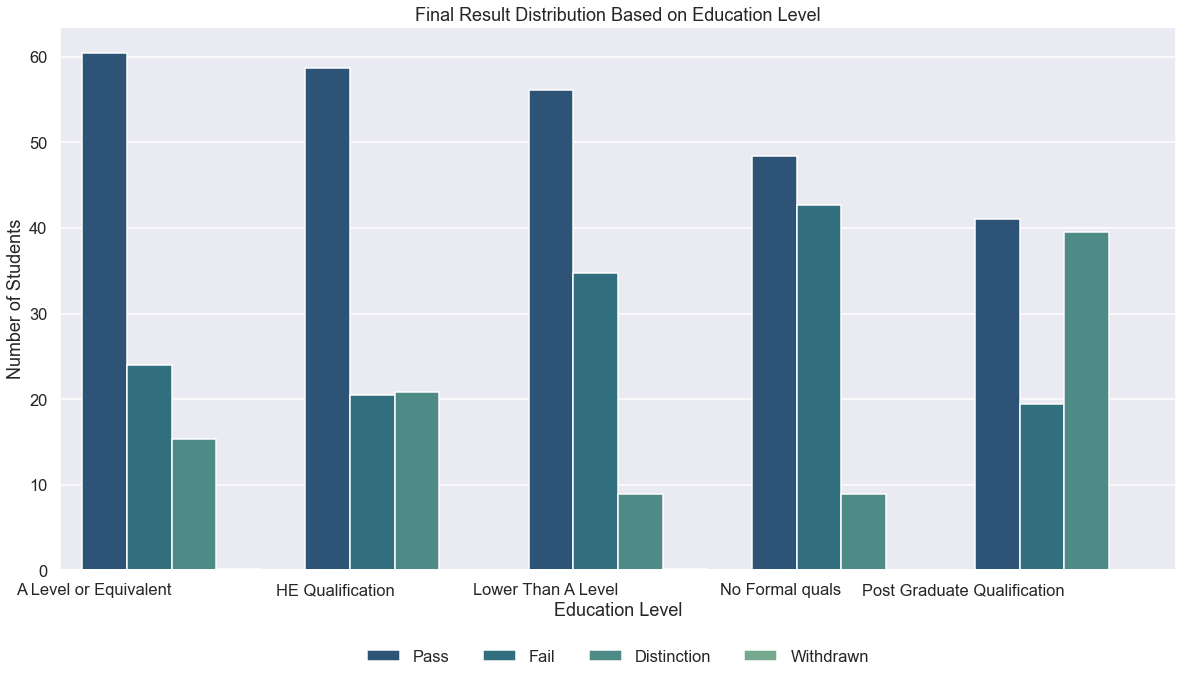

In [23]:
edu_pnt = df.groupby('highest_education')['final_result'].value_counts(normalize = True).reset_index(name='Percentage')
edu_pnt['Percentage'] = edu_pnt['Percentage'] * 100
fig, ax = plt.subplots(figsize =(20,10))
plt.xticks(horizontalalignment='right')

sns.barplot(x='highest_education', y ='Percentage',data=edu_pnt,  hue='final_result', palette='crest_r')

plt.xlabel('Education Level')
plt.ylabel('Number of Students')
plt.title('Final Result Distribution Based on Education Level')
plt.legend(loc = 'lower center', bbox_to_anchor=(0.5, -0.2), ncol = 4)
plt.show()

* Students with lower than A level o education have higher rate of failing

In [24]:
cross_tab = pd.crosstab(df['highest_education'], df['final_result'])

In [25]:
chi_sq, p_val, dof, con_table = stats.chi2_contingency(cross_tab)
print(f'Chi-Squared = {chi_sq}')
print(f'p-value= {p_val}')
print(f'Degrees of Freedom = {dof}')

Chi-Squared = 602.258286447592
p-value= 3.4922433503854758e-121
Degrees of Freedom = 12


* The low p-value indicates that there is a statistically significant relation between level of education and outcome

In [26]:
ed.percentage(cross_tab)

,Pass,Fail,Withdraw,Distinct,Success,Failure
A Level or Equivalent,60.49,24.02,0.11,15.39,75.88,24.13
HE Qualification,58.67,20.47,0.06,20.79,79.46,20.53
Lower Than A Level,56.16,34.79,0.11,8.94,65.1,34.9
No Formal quals,48.41,42.68,0.0,8.92,57.33,42.68
Post Graduate Qualification,41.01,19.42,0.0,39.57,80.58,19.42


* Students with **no formal qualifications** have lowest rate of passing, while students with **Post Grad level of education** have highest rates.
* Students with **A level of education or lower** tend to withdraw more than students with other levels of education.

## Final Result Based on IMD Band

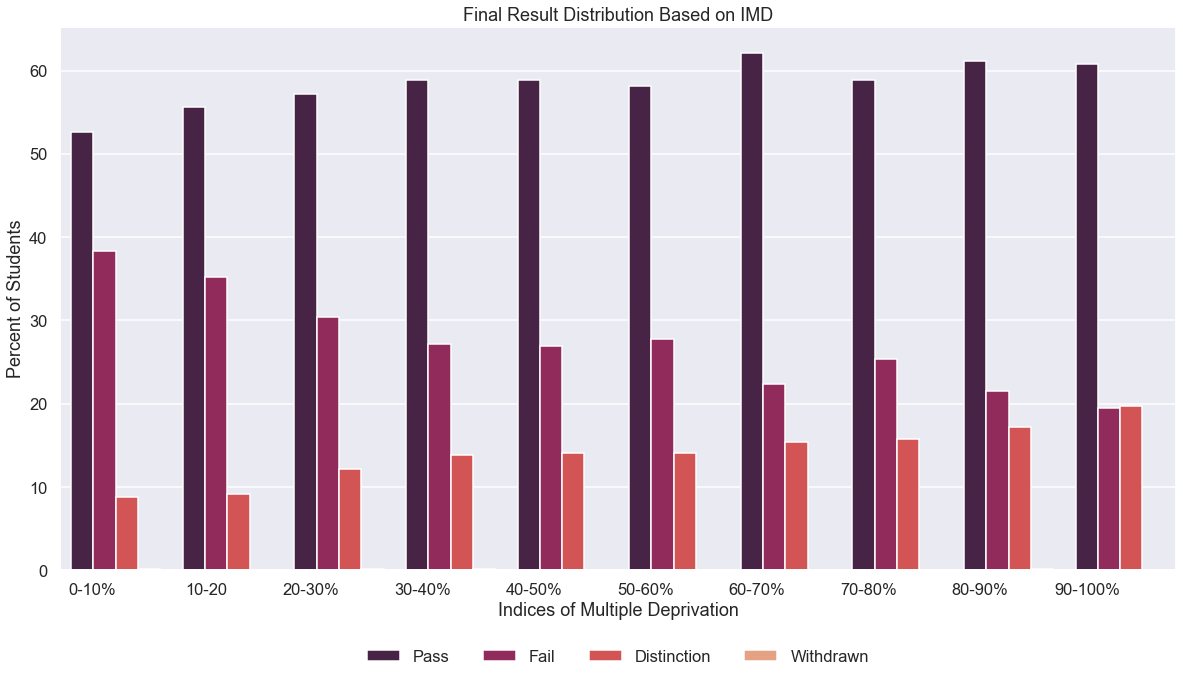

In [27]:
imd_pnt = df.groupby('imd_band')['final_result'].value_counts(normalize = True).reset_index(name='Percentage')
imd_pnt['Percentage'] = imd_pnt['Percentage'] * 100
fig, ax = plt.subplots(figsize =(20,10))
plt.xticks(horizontalalignment='right')

sns.barplot(x='imd_band', y ='Percentage',data=imd_pnt,  hue='final_result', palette='rocket')

plt.xlabel('Indices of Multiple Deprivation')
plt.ylabel('Percent of Students')
plt.legend(loc = 'lower center', bbox_to_anchor=(0.5, -0.2), ncol = 4)
plt.title('Final Result Distribution Based on IMD')
plt.show()

* In all groups, the passing percentage has highest value.

In [28]:
cross_tab = pd.crosstab(df['imd_band'], df['final_result'])

In [29]:
chi_sq, p_val, dof, con_table = stats.chi2_contingency(cross_tab)
print(f'Chi-Squared = {chi_sq}')
print(f'p-value= {p_val}')
print(f'Degrees of Freedom = {dof}')

Chi-Squared = 391.26436226332146
p-value= 2.9950829043913963e-66
Degrees of Freedom = 27


* The low p-value indicates that there is a statistically significant relation between imd_band and outcome

In [30]:
ed.percentage(cross_tab)

,Pass,Fail,Withdraw,Distinct,Success,Failure
0-10%,52.65,38.28,0.21,8.85,61.5,38.49
10-20,55.57,35.21,0.1,9.13,64.7,35.31
20-30%,57.2,30.45,0.14,12.21,69.41,30.59
30-40%,58.82,27.22,0.18,13.79,72.61,27.4
40-50%,58.84,26.94,0.1,14.12,72.96,27.04
50-60%,58.17,27.73,0.0,14.1,72.27,27.73
60-70%,62.15,22.4,0.05,15.4,77.55,22.45
70-80%,58.85,25.35,0.05,15.74,74.59,25.4
80-90%,61.09,21.56,0.11,17.25,78.34,21.67
90-100%,60.75,19.46,0.06,19.73,80.48,19.52


* The higher the imd_band, the higher is the rate of passing result

## Final Result Based on Age Band

In [31]:
age_pnt = df.groupby('age_band')['final_result'].value_counts(normalize = True).reset_index(name='Percentage')
age_pnt['Percentage'] = age_pnt['Percentage'] * 100
age_pnt

,age_band,final_result,Percentage
0,0-35,Pass,57.815282
1,0-35,Fail,29.609058
2,0-35,Distinction,12.454604
3,0-35,Withdrawn,0.121057
4,35-55,Pass,59.744568
5,35-55,Fail,23.055233
6,35-55,Distinction,17.150440
7,35-55,Withdrawn,0.049759
8,55<=,Pass,56.578947
9,55<=,Distinction,25.000000


In [32]:
df.age_band.value_counts(normalize = True)

0-35     0.694373
35-55    0.298111
55<=     0.007516
Name: age_band, dtype: float64

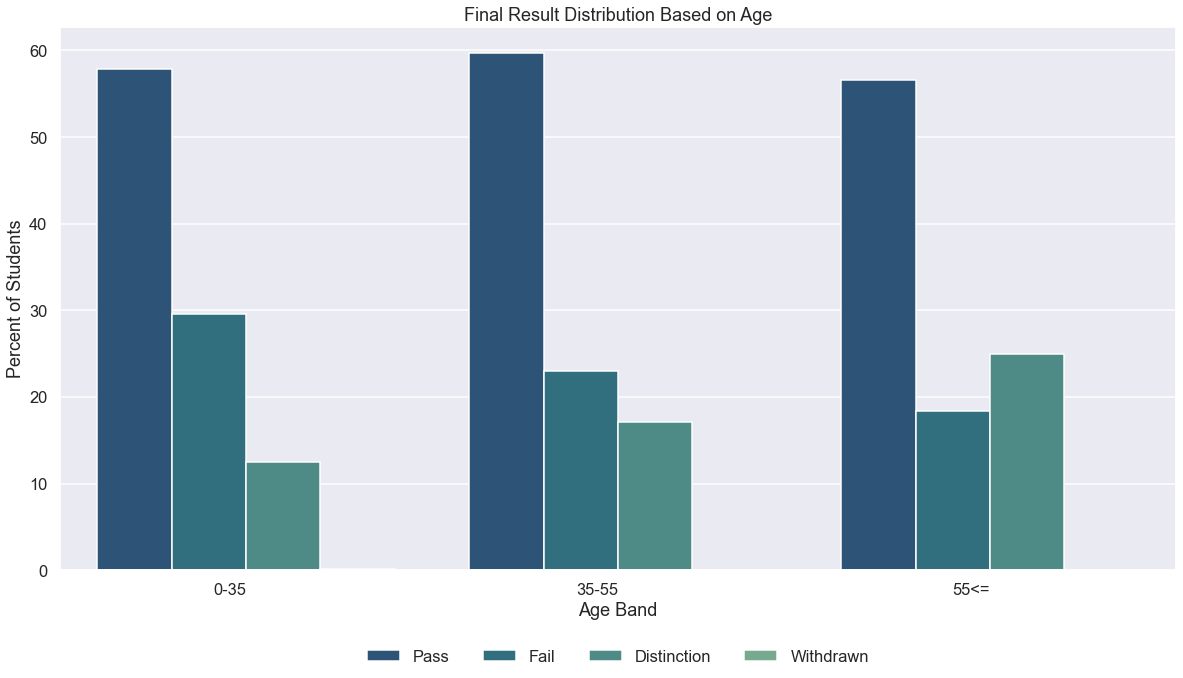

In [33]:
fig, ax = plt.subplots(figsize =(20,10))
plt.xticks(horizontalalignment='right')

sns.barplot(x='age_band', y ='Percentage',data=age_pnt,  hue='final_result', palette='crest_r')

plt.xlabel('Age Band')
plt.ylabel('Percent of Students')
plt.legend(loc = 'lower center', bbox_to_anchor=(0.5, -0.2), ncol = 4)
plt.title('Final Result Distribution Based on Age')
plt.show()

* Based on the graph, students in 55 and up age range have highest rate of disctinct results.

In [34]:
cross_tab = pd.crosstab(df['age_band'], df['final_result'])

In [35]:
chi_sq, p_val, dof, con_table = stats.chi2_contingency(cross_tab)
print(f'Chi-Squared = {chi_sq}')
print(f'p-value= {p_val}')
print(f'Degrees of Freedom = {dof}')

Chi-Squared = 155.54802380577758
p-value= 5.187781900484835e-31
Degrees of Freedom = 6


* The low p-value indicates that there is a statistically significant relation between age_band and outcome

In [36]:
ed.percentage(cross_tab)

,Pass,Fail,Withdraw,Distinct,Success,Failure
0-35,57.82,29.61,0.12,12.45,70.27,29.73
35-55,59.74,23.06,0.05,17.15,76.89,23.11
55<=,56.58,18.42,0.0,25.0,81.58,18.42


* The higher the age_band, the higher is the rate of success. 
* Students in age range of 0-35 tend to withdraw more than students that are older.

## Disability vs Final Result

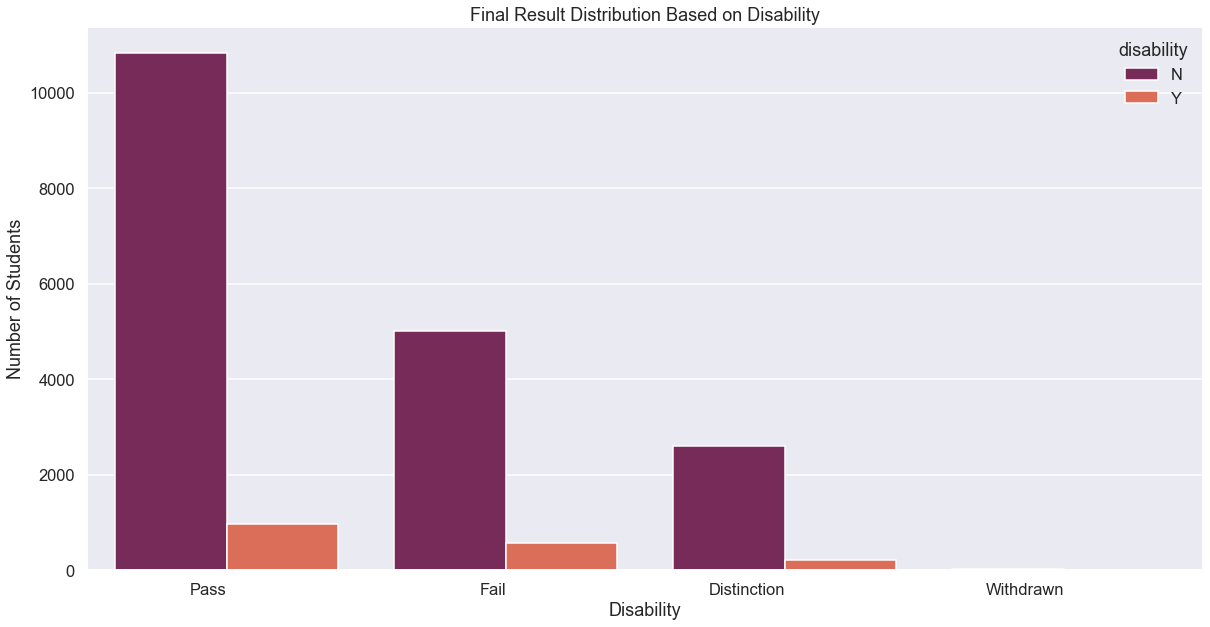

In [37]:
fig, ax = plt.subplots(figsize =(20,10))
plt.xticks(horizontalalignment='right')

sns.countplot(x="final_result", hue="disability", palette="rocket", data=df)

plt.xlabel('Disability')
plt.ylabel('Number of Students')
plt.title('Final Result Distribution Based on Disability')
plt.show()

In [38]:
cross_tab = pd.crosstab(df['disability'], df['final_result'])

In [39]:
chi_sq, p_val, dof, con_table = stats.chi2_contingency(cross_tab)
print(f'Chi-Squared = {chi_sq}')
print(f'p-value= {p_val}')
print(f'Degrees of Freedom = {dof}')

Chi-Squared = 24.300591969297166
p-value= 2.1618326380559615e-05
Degrees of Freedom = 3


* The low p-value indicates that there is a statistically significant relation between disability and outcome

In [40]:
ed.percentage(cross_tab)

,Pass,Fail,Withdraw,Distinct,Success,Failure
N,58.7,27.1,0.1,14.1,72.8,27.2
Y,55.06,32.5,0.11,12.33,67.39,32.61


* Students with **no disability** have slightly larger passing rate than students **with disability.**

# Modeling

In [41]:
df = pd.read_csv('../../data/final_data.csv', dtype={"id_student": str})

In [42]:
df.drop(columns = ['id_student', 'code_presentation'], inplace = True)
df.rename(columns = {'module_presentation_length': 'course_length', 
                     'num_of_prev_attempts': 'attempts'}, inplace = True)

## Features

* **course_length:** length of the code_module in days.
* **code_module:** three letter id of the course.
* **date_registration:** number of days student registered before the course beginning.
* **sum_click:** sum of click student made on Vle for given course.
* **gender:** gender of the student.
* **region:** region of student location in UK.
* **highest_education:** education level of the student.
* **imd_band:** indices of multiple deprivation - a measure of economic status.
* **age_band:** age category of the student.
* **attempts:** number of times the student has attempted the class.
* **disability:** disability status of the student.
* **studied credits:** number of credits student acquired by the begginning of the course.
* **mean_score:** The student's mean assessment score.


### Binarize Classes

* For the purpose of modeling, I will binarize the target labels, such that Fail/Withdraw - 1, and Pass/Distinc - 0.

In [43]:
df['final_result'] = df['final_result'].apply(lambda x: 0 if ('Pass' in x or 'Distinct' in x ) else 1)
df['final_result'].value_counts()

0    14628
1     5596
Name: final_result, dtype: int64

* Classes are imbalanced.

In [44]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20224 entries, 0 to 20223
Data columns (total 14 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   course_length      20224 non-null  int64  
 1   code_module        20224 non-null  object 
 2   date_registration  20224 non-null  int64  
 3   sum_click          20224 non-null  int64  
 4   gender             20224 non-null  object 
 5   region             20224 non-null  object 
 6   highest_education  20224 non-null  object 
 7   imd_band           20224 non-null  object 
 8   age_band           20224 non-null  object 
 9   attempts           20224 non-null  int64  
 10  studied_credits    20224 non-null  int64  
 11  disability         20224 non-null  object 
 12  final_result       20224 non-null  int64  
 13  mean_score         20224 non-null  float64
dtypes: float64(1), int64(6), object(7)
memory usage: 2.2+ MB


## Feature Correlation

Explore how correlated numeric features are.

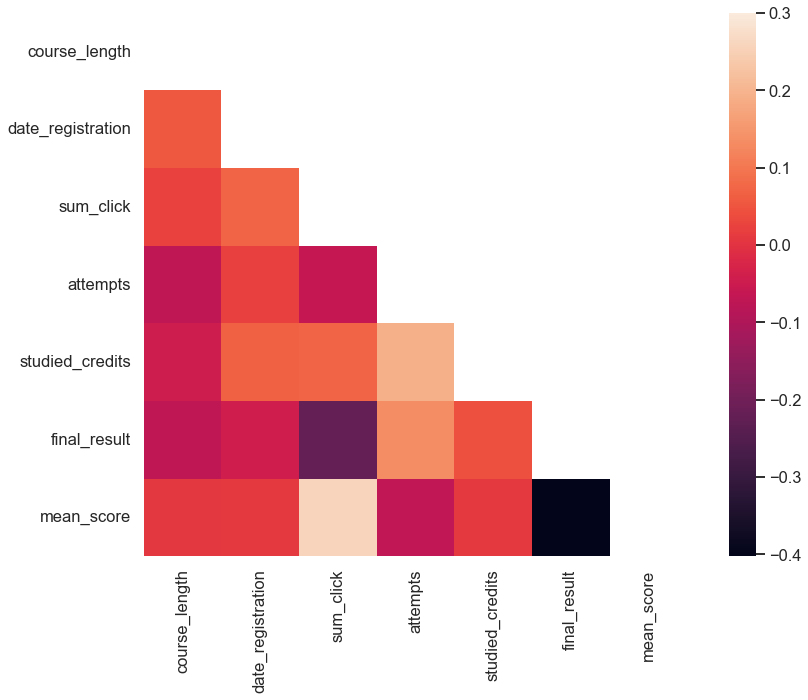

In [45]:
corr = df.corr(method = 'pearson')

mask = np.triu(np.ones_like(corr, dtype='bool'))

with sns.axes_style("white"):
    f,ax = plt.subplots(figsize = (15,10))
    ax = sns.heatmap(corr, mask = mask, vmax = 0.3, square = True)

In [46]:
corr_matrix = df.corr()
corr_mat = corr_matrix["final_result"].sort_values(ascending=False)
print(corr_mat)

final_result         1.000000
attempts             0.132633
studied_credits      0.044604
date_registration   -0.042975
course_length       -0.072593
sum_click           -0.220464
mean_score          -0.402654
Name: final_result, dtype: float64


### Train-Test Split

To prevent models from **overfitting** and to be able to **accurately evaluate model** I will split the data to **X as a features and y as a target variable, and split data into three sets: train, test and holdout.**

In [47]:
X = df.drop("final_result", axis=1)
y = df['final_result']

Now, split the data to **train and holdout sets** and then **split the train set into test and train sets too.**

In [48]:
x_all, x_hold, y_all, y_hold = train_test_split(X, y, train_size = 0.80, random_state=2021)
x_train, x_test, y_train, y_test = train_test_split(x_all, y_all, train_size = 0.75,random_state=2021)

### Data Imbalance

I will check how balanced my train data is based on target feature

In [49]:
pd.Series(y_train).value_counts(normalize=True)

0    0.720949
1    0.279051
Name: final_result, dtype: float64

* It is clear that train set is imbalanced. I will build first model with this data and later on try to balance it using SMOTE.

## Baseline Model - Logistic Regression

### ColumnTransformer for Categorical Features

Before I start any modeling, I will use **ColumnTransformer and OneHotEncode** all categorical features of the dataframe:

In [50]:
cat_cols = x_train.select_dtypes(include='object').columns
indices = []
for col in cat_cols:
    indices.append(x_train.columns.get_loc(col))
indices

[1, 4, 5, 6, 7, 8, 11]

In [51]:
transformer = ColumnTransformer(transformers=[('categorical', 
                                               OneHotEncoder(handle_unknown = 'ignore'), indices)], 
                                remainder = 'passthrough')

### Build Logistic Regression Pipeline

* The pipeline will apply following transformers: ColumnTransformer, StandardScaler.

In [52]:
base_model_pipe = make_pipeline(transformer, StandardScaler(with_mean = False), 
                               LR(C=0.01, random_state=2021, max_iter = 5000))

base_model_pipe.fit(x_train, y_train)
base_model_pipe.score(x_test, y_test)

history = mh.ModelHistory()

In [53]:
history.report(base_model_pipe,x_train, y_train, 'Logistic Regression', 
               'Regression with All Features and Imbalanced Data')

Average Accuracy Score: 0.7804530409851539
Average Recall Score: 0.3983748088897073
Average Precision Score: 0.6819532673637891
Average F1 Score: 0.5024905647920963


* **Get predictions for both train and test splits.**

In [54]:
train_preds = base_model_pipe.predict(x_train)
test_preds = base_model_pipe.predict(x_test)

* **Print out evaluation metrics by calling user defined function**

In [55]:
mf.print_metrics(y_train,train_preds)
mf.print_metrics(y_test,test_preds)

Precision Score: 0.6864321608040201
Recall Score: 0.40342587123449497
Accuracy Score: 0.7820998846217241
F1 Score: 0.5081845238095237


Precision Score: 0.6597325408618128
Recall Score: 0.3918799646954987
Accuracy Score: 0.773053152039555
F1 Score: 0.49169435215946844




* **Confusion Matrix**

<Figure size 720x720 with 0 Axes>

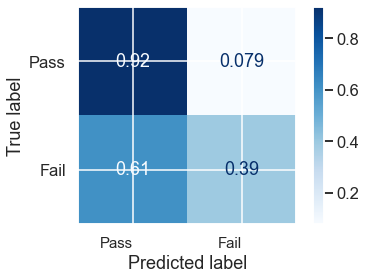

In [56]:
mf.confusion_mtx(base_model_pipe, x_test, y_test)


In [57]:
residuals = y_train == train_preds

print('Number of values correctly predicted:')
print(pd.Series(residuals).value_counts())

Number of values correctly predicted:
True     9490
False    2644
Name: final_result, dtype: int64


In [58]:
residuals = y_test == test_preds

print('Number of values correctly predicted:')
print(pd.Series(residuals).value_counts())

Number of values correctly predicted:
True     3127
False     918
Name: final_result, dtype: int64


**Model Results:**
* There is no overfitting since model evaluation scores for train and test splits are close enough to each other.
* From confusion matrix it is clear that model predicting most of the outcomes as "Pass", due to class imbalance
* About 1/3 of outcomes of test data were predicted falsely based on residuals

## Logistic Regression with Upsampled Data

Since the classes of the target are imbalanced, I will use **SMOTE()** in the pipeline **to upsample data.**

In [59]:
upsample_pipe = make_pipeline(transformer, StandardScaler(with_mean = False), 
                              SMOTE(random_state = 2021), 
                              LR(C=0.01, random_state=2021, max_iter = 5000))

upsample_pipe.fit(x_train, y_train)

history.report(upsample_pipe,x_train, y_train, 'Logistic Regression', 
               'Logistic Regression with Upsampled Data')

Average Accuracy Score: 0.733558470767672
Average Recall Score: 0.7105936715774724
Average Precision Score: 0.5163829966986826
Average F1 Score: 0.5979641622955632


* **Get predicted values for train and test splits**

In [60]:
train_preds = upsample_pipe.predict(x_train)
test_preds = upsample_pipe.predict(x_test)

* **Evaluation Metrics**

In [61]:
mf.print_metrics(y_train,train_preds)
mf.print_metrics(y_test,test_preds)

Precision Score: 0.5222724338282763
Recall Score: 0.716774955699941
Accuracy Score: 0.7380089006098566
F1 Score: 0.6042574380679696


Precision Score: 0.5218811234487263
Recall Score: 0.705207413945278
Accuracy Score: 0.7364647713226206
F1 Score: 0.5998498498498498




* **Confusion Matrix**

<Figure size 720x720 with 0 Axes>

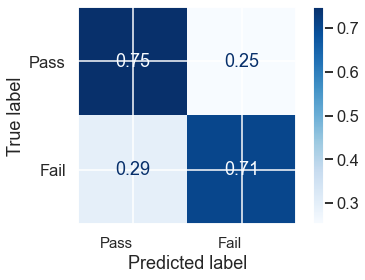

In [62]:
mf.confusion_mtx(upsample_pipe, x_test, y_test)

In [63]:
residuals = y_train == train_preds

print('Number of values correctly predicted:')
print(pd.Series(residuals).value_counts())

Number of values correctly predicted:
True     8955
False    3179
Name: final_result, dtype: int64


In [64]:
residuals = y_test == test_preds

print('Number of values correctly predicted:')
print(pd.Series(residuals).value_counts())

Number of values correctly predicted:
True     2979
False    1066
Name: final_result, dtype: int64


**Model Results:**

* Upsampled model performed worse than imbalanced data in terms of evaluation metrics - the recall score got lower
* The confusion matrix shows better performance in term of high diagonal values.
* The value of false negatives went down

## Other Models

**Models**: KNN, Decision Tree, Random Forest, XGBoost, GradientBoost.

**Pipelines**: ColumnTansformer, Statdard Scaler, SMOTE, model

**Results**: 

* **KNN** - overfitting train set
* **Decision Tree** - high false negative value
* **Random Forest** - high false negative value
* **XGBoost** - overfitting train set, high false negative value
* **Gradient Boost** - overfitting train set, high false negative value

## GridSearch for Best Model Parameters

In [65]:
models = {LR: {'C': [0.01, 0.02, 0.03, 0.05, 0.1, 0,2, 0.3, 0.5],
               'max_iter': [50, 100, 200, 500],
               'penalty': ['l2', 'l1', 'elasticnet', None],
               'solver': ['newton-cg', 'lbfgs', 'saga'], 
               'random_state': [2021]},
          KNN: {'metric': ['euclidean', 'manhattan'],
                'n_neighbors': [2, 3, 4, 5, 7, 10, 15],
                'weights': ['uniform', 'distance']},
          DT: {'criterion': ['gini', 'entropy'],
               'max_depth': [None, 4, 5, 7, 10],
               'min_samples_split': [2, 3, 5, 10],
               'random_state': [2021]}}

In [66]:
# tuned_models = {}

# for model, params in models.items():
#     pipe = make_pipeline(transformer, StandardScaler(with_mean = False),
#                          SMOTE(),model())
    
#     model_name = model.__name__.lower()
#     parameters = dict(map(lambda x: (model_name +'__'+x[0], x[1]), params.items()))
    
#     grid = GridSearchCV(pipe, parameters)
#     grid.fit(x_train, y_train)
#     tuned_models[model_name] = grid.best_estimator_.get_params()

## Logistic Regression with GridSearched Parameters

In [67]:
lr_best_pipe = make_pipeline(transformer, StandardScaler(with_mean = False), 
                             SMOTE(), LR(C=0.1, max_iter=50, random_state=2021, solver='saga'))

In [68]:
lr_best_pipe.fit(x_train, y_train)
lr_best_pipe.score(x_test, y_test)

0.7344870210135971

In [69]:
history.report(lr_best_pipe,x_train, y_train, 'Logistic Regression - Best Params', 
               'Logistic Regression with GridSearched Parameters')

Average Accuracy Score: 0.7359480151190222
Average Recall Score: 0.7126931082274306
Average Precision Score: 0.5196049237487894
Average F1 Score: 0.6008902824139604


* **Predicted Values**

In [70]:
train_preds = lr_best_pipe.predict(x_train)
test_preds = lr_best_pipe.predict(x_test)

* **Evaluation Metrics**

In [71]:
mf.print_metrics(y_train,train_preds)
mf.print_metrics(y_test,test_preds)

Precision Score: 0.5197522955370489
Recall Score: 0.7188422917897224
Accuracy Score: 0.7361958134168453
F1 Score: 0.6032965671086876


Precision Score: 0.518946692357097
Recall Score: 0.7131509267431597
Accuracy Score: 0.7344870210135971
F1 Score: 0.6007434944237918




* **Confusion Matrix**

<Figure size 720x720 with 0 Axes>

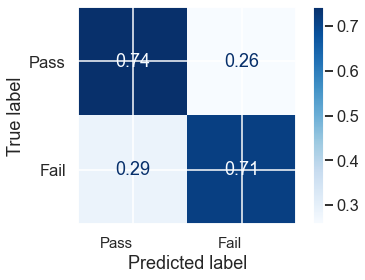

In [72]:
mf.confusion_mtx(lr_best_pipe, x_test, y_test)

# Modeling Results

Based on the **Recall and F1** Scores, the **Logistic Regression Model** with Grid Searched parameters has performed the best - **Recall(0.71), F1(0.59).** The **confusion matrix** shows **lowest values for false negative** predictions - predicting pass, while student is failing. I will **test the model on holdout data.** 


## Predicting on Holdout Data

In [73]:
train_preds = lr_best_pipe.predict(x_train)
hold_preds = lr_best_pipe.predict(x_hold)

In [74]:
mf.print_metrics(y_train,train_preds)
mf.print_metrics(y_hold,hold_preds)

Precision Score: 0.5197522955370489
Recall Score: 0.7188422917897224
Accuracy Score: 0.7361958134168453
F1 Score: 0.6032965671086876


Precision Score: 0.5069974554707379
Recall Score: 0.7400185701021356
Accuracy Score: 0.7391841779975278
F1 Score: 0.6017365043412609




<Figure size 720x720 with 0 Axes>

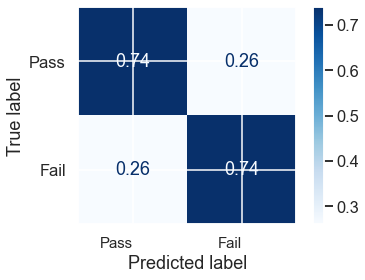

In [75]:
mf.confusion_mtx(lr_best_pipe, x_hold, y_hold)


### Results:

* Model showed better performance on holdout data than on test data. The value for false negatives on hold data is 0.26 based on confusion matrix.
* The recall score of 0.74 indicates that 74% of the results were predicted truly as Fail, and 0.78 precision indicates that 78% of final results were correctly predicted as Pass.

<Figure size 720x720 with 0 Axes>

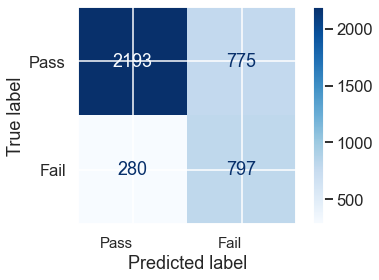

In [76]:
plt.figure(figsize =(10,10))
plot_confusion_matrix(lr_best_pipe, x_hold, y_hold,
                     cmap=plt.cm.Blues, display_labels=
                          ['Pass', 'Fail'])

plt.xticks(horizontalalignment='right', fontsize='small')
plt.show()

## Feature Importance Logistic Regression

In [77]:
x_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12134 entries, 1739 to 5312
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   course_length      12134 non-null  int64  
 1   code_module        12134 non-null  object 
 2   date_registration  12134 non-null  int64  
 3   sum_click          12134 non-null  int64  
 4   gender             12134 non-null  object 
 5   region             12134 non-null  object 
 6   highest_education  12134 non-null  object 
 7   imd_band           12134 non-null  object 
 8   age_band           12134 non-null  object 
 9   attempts           12134 non-null  int64  
 10  studied_credits    12134 non-null  int64  
 11  disability         12134 non-null  object 
 12  mean_score         12134 non-null  float64
dtypes: float64(1), int64(5), object(7)
memory usage: 1.3+ MB


In [78]:
num_vars = ['course_length', 'date_registration', 'sum_click', 'attempts', 'studied_credits', 'mean_score']

cat_vars = upsample_pipe.named_steps['columntransformer'].transformers_[0][1].get_feature_names().tolist()

features_df = list(zip(num_vars + cat_vars, upsample_pipe.named_steps['logisticregression'].coef_[0]))

In [79]:
feature_importance = pd.DataFrame(features_df, columns = ["feature", "importance"])
feature_importance = feature_importance.sort_values(by = ["importance"], ascending=False)

<BarContainer object of 48 artists>

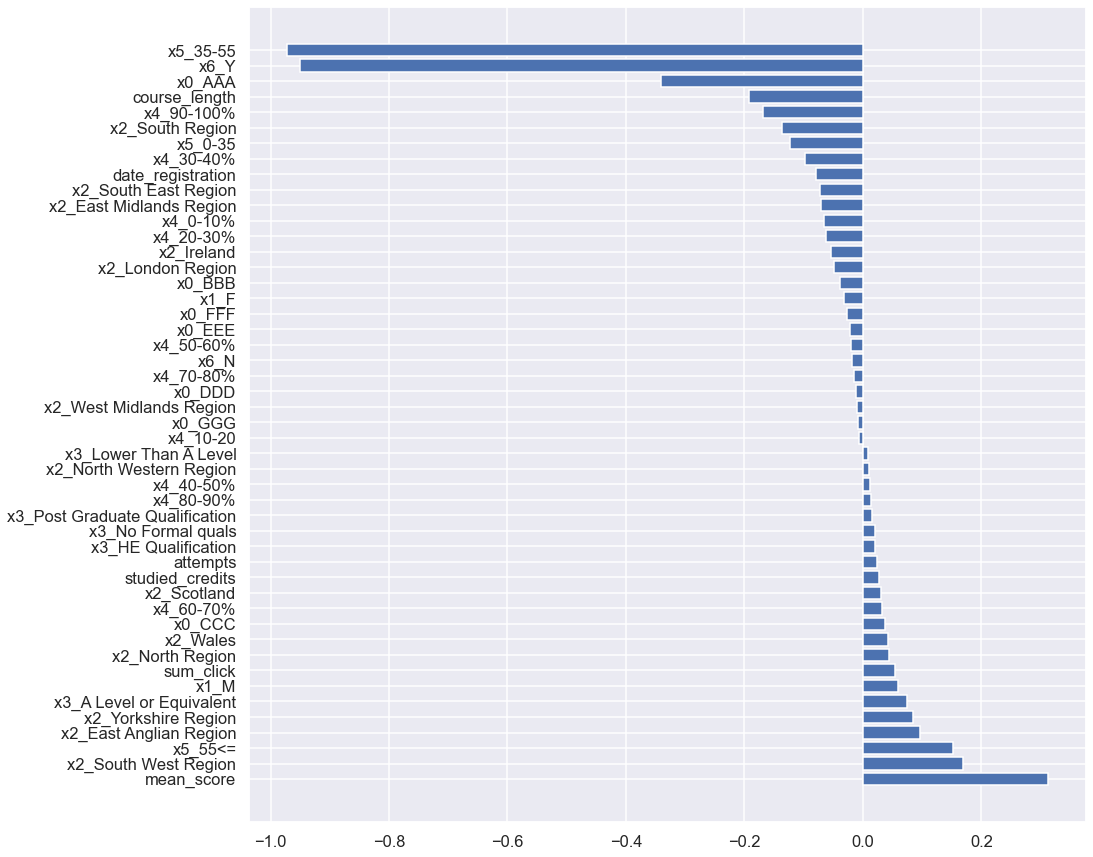

In [80]:
fig, ax = plt.subplots(figsize = (15,15))
ax.barh(width=feature_importance.importance, y=feature_importance.feature)

### ANOVA Test for Numeric Features

In [81]:
formula = 'final_result ~ date_registration + sum_click + studied_credits + course_length + mean_score'
lm = ols(formula, df).fit()
table = sm.stats.anova_lm(lm, typ=2)
print(table)

                        sum_sq       df            F        PR(>F)
date_registration     3.756658      1.0    23.029012  1.607141e-06
sum_click            59.332146      1.0   363.717068  2.218663e-80
studied_credits      12.704254      1.0    77.879436  1.182589e-18
course_length        15.760942      1.0    96.617497  9.458148e-23
mean_score          517.923612      1.0  3174.967895  0.000000e+00
Residual           3298.105662  20218.0          NaN           NaN


# Conclusion

The Logistic Regression model was able to predict 74% of failing students, with falsely predicting only 26% as passing. Based on the EDA, statistical analysis and modeling, following are appropriate steps to take in order to navigate students and increase success rate of institution.

## Recommendations

1. Assist students with Lower than A level of education: provide additional sources for studying and tutoring.
2. Provide excessive support for students who are located in regions with low imd.
3. Advise students in lower age range to closely communicate with students that are older.

4. The critical role in determining the students outcome is played by the score on assessments, thus the additional study sources would be helpfull for students success.
5. The level of interaction of student on online tools has significant impact on the final result, thus advise students to closely interact with online study materials
6. Course length plays small but statistically significant role in outcome, therefore determine optimal course length.



## Future Steps

1. Build a multilabel model to examine the performance compared to binary models
2. Include the Activity type on online sources as a feature.
3. Include time based features related to assessments and student interactions to explore prediction performance.